In [12]:
#from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from models.DECAF import DECAF
from data import DataModule
import os
from metrics import eval_model
from data import load_credit, inject_synth_bias, preprocess_credit

## Load and Preprocess dataset

In [13]:
df= load_credit()
credit_data = preprocess_credit(df)
print(credit_data["approved"].value_counts())
names = list(credit_data.columns)

1.0    373
0.0    305
Name: approved, dtype: int64


## Get the dag used in paper

In [14]:
# Define DAG for Credit dataset
dag= [    
    # Edges from age
    ['age', 'yearsemployed'],
    
    # Edges from ethnicity
    ['ethnicity', 'approved'],
    ['ethnicity', 'married'],
    
    # Edges from default
    ["priordefault", "creditscore"],
    ["priordefault", "approved"],
    ["priordefault", "employed"],
    
    # Edges from zip
    ["zip", "married"],
    # Edges from citizen
    ["citizen","married"],
    # Edges from driverslicense
    ["driverslicense","employed"],
    # Edges from education_level
    ["educationlevel","employed"],
    ["educationlevel","married"],
    
    # Edges from yearsemployed
    ["yearsemployed", "creditscore"],
    # Edges from creditscore
    ["creditscore", "approved"],
    ["creditscore", "debt"],
    
    # Edges from employed
    ["employed", "bankcustomer"],
    ["employed", "debt"],
    ["employed", "citizen"],
    
    # Edges from debt
    ["debt", "income"],
    # Edges from married
    ["married", "approved"],
    
    # Edges from income
    ["income", "approved"],
    ["income", "married"],
]

def dag_to_idx(df, dag):
    """Convert columns in a DAG to the corresponding indices."""

    dag_idx = []
    for edge in dag:
        dag_idx.append([df.columns.get_loc(edge[0]), df.columns.get_loc(edge[1])])

    return dag_idx

#Convert the DAG to one that can be provided to the DECAF model
dag_seed_paper = dag_to_idx(credit_data, dag)
print("dag_seed of paper: ",dag_seed_paper)

dag_seed of paper:  [[1, 7], [6, 15], [6, 3], [8, 10], [8, 15], [8, 9], [13, 3], [12, 3], [11, 9], [5, 9], [5, 3], [7, 10], [10, 15], [10, 2], [9, 4], [9, 2], [9, 12], [2, 14], [3, 15], [14, 15], [14, 3]]


## Define edge for different fairness

In [15]:
def create_bias_dict(df, edge_map):
    """
    Convert the given edge tuples to a bias dict used for generating
    debiased synthetic data.
    """
    bias_dict = {}
    for key, val in edge_map.items():
        bias_dict[df.columns.get_loc(key)] = [df.columns.get_loc(f) for f in val]
    
    return bias_dict

bias_dict_nd = {}
print('Bias dict ND:', bias_dict_nd)

# Bias dictionary to satisfy FTU
bias_dict_ftu = create_bias_dict(credit_data, {'approved': ['ethnicity']})
print('Bias dict FTU:', bias_dict_ftu)

# Bias dictionary to satisfy DP
bias_dict_dp = create_bias_dict(credit_data, {'approved': ['married','ethnicity']})
print('Bias dict DP:', bias_dict_dp)

Bias dict ND: {}
Bias dict FTU: {15: [6]}
Bias dict DP: {15: [3, 6]}


## Evaluation on original dataset

In [16]:
def debais_orig_credit():
    label = "approved"
    df= load_credit()
    credit_data = preprocess_credit(df)
    dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)

    total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
    for i in range(10):
        dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)
        single_result = eval_model(dataset_train = dataset_train, dataset_test = dataset_test)
        for key in total_result:
            total_result[key].append(single_result[key])

        final_result = []
    for key in total_result:
        final_result += [np.mean(total_result[key])]
        final_result += [np.std(total_result[key])]
    print("final_result: ",final_result)
        
    return final_result


col_names =['name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
df = pd.DataFrame(columns = col_names)
orig_result = debais_orig_credit()
df.loc[len(df)] =(["ftu"]+orig_result)
df
#dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2)
#eval_model(dataset_train, dataset_test)

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

final_result:  [0.9129156010230177, 0.00038363171355497715, 0.78625, 0.003749999999999987, 0.8395535714285716, 0.0018750000000000266, 0.005606380483227746, 0.003448275862068994, 0.004411764705882337, 0.004877389397581453]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,name,precision_mean,precision_std,recall_mean,recall_std,auroc_mean,auroc_std,dp_mean,dp_std,ftu_mean,ftu_std
0,ftu,0.912916,0.000384,0.78625,0.00375,0.839554,0.001875,0.005606,0.003448,0.004412,0.004877


##  Train DECAF

In [17]:
models_dir = './cache/'
def train_decaf(train_dataset, dag_seed, biased_edges={}, dataset="adult",label="income", bias=0, h_dim=200, lr=0.5e-3,
                batch_size=64, lambda_privacy=0, lambda_gp=10, d_updates=10,
                alpha=2, rho=2, weight_decay=1e-2, grad_dag_loss=False, l1_g=0,
                l1_W=1e-4, p_gen=-1, use_mask=True, epochs=50):
    model_filename = os.path.join(models_dir, 'decaf_'+dataset+str(bias)+'.pkl')
    dm = DataModule(train_dataset.values)

    model = DECAF(
        dm.dims[0],
        dag_seed=dag_seed,
        h_dim=h_dim,
        lr=lr,
        batch_size=batch_size,
        lambda_privacy=lambda_privacy,
        lambda_gp=lambda_gp,
        d_updates=d_updates,
        alpha=alpha,
        rho=rho,
        weight_decay=weight_decay,
        grad_dag_loss=grad_dag_loss,
        l1_g=l1_g,
        l1_W=l1_W,
        p_gen=p_gen,
        use_mask=use_mask,
    )
    print("model name: ",model_filename)
    if os.path.exists(model_filename):
        model = torch.load(model_filename)
    else:
        trainer = pl.Trainer(max_epochs=epochs, logger=False)
        trainer.fit(model, dm)
        torch.save(model, model_filename)

    # Generate synthetic data
    synth_dataset = (
        model.gen_synthetic(
            dm.dataset.x,
            gen_order=model.get_gen_order(),
            biased_edges=biased_edges,
        )
        .detach()
        .numpy()
    )
    synth_dataset[:, -1] = synth_dataset[:, -1].astype(np.int8)

    synth_dataset = pd.DataFrame(synth_dataset,
                                 index=train_dataset.index,
                                 columns=train_dataset.columns)
    synth_dataset["ethnicity"] = np.round(synth_dataset["ethnicity"])

    return synth_dataset

In [21]:
def injected_bias(biased_edges={},name="nd"):
    # calculate injected bias result and save to dataframe
    col_names =['bias','name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
    df = pd.DataFrame(columns = col_names)
    
    label = "approved"
    data= load_credit()
    credit_data = preprocess_credit(data)

    for bias in [0,0.25,0.5,0.75,1]:
        biased_data = inject_synth_bias(credit_data, bias=bias)
        if bias<0:
            biased_data = credit_data
            
        biased_train, biased_test = train_test_split(biased_data, test_size=0.2)
        X_train, y_train = biased_train.drop(columns=[label]), biased_train[label]
        mlp = MLPClassifier().fit(X_train, y_train)
        

        #calculate DECAF-ND
        total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
        for i in range(10):
            synth_data = train_decaf(biased_train, dag_seed_paper, dataset="credit",label="approved",bias=bias, epochs=250,biased_edges=biased_edges)
            y_synth = mlp.predict(synth_data.drop(columns=[label]))
            synth_data[label]= y_synth
            single_result = eval_model(dataset_train = synth_data, dataset_test = biased_data)

            for key in total_result:
                total_result[key].append(single_result[key])
        
        final_result = []
        for key in total_result:
            final_result += [np.mean(total_result[key])]
            final_result += [np.std(total_result[key])]
        print("final_result: ",final_result)
        df.loc[len(df)] =([bias]+[name]+final_result)
    
    df.to_csv("result/credit_"+name+".csv", index = False, header=True)

In [19]:
def debais_credit(biased_edges={}):
    label = "approved"
    df= load_credit()
    credit_data = preprocess_credit(df)
    dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)
    X_train, y_train = dataset_train.drop(columns=[label]), dataset_train[label]
    mlp = MLPClassifier().fit(X_train, y_train)

    total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
    for i in range(10):
        synth_data = train_decaf(biased_data, dag_seed_paper, dataset="credit",label="approved",bias=-1, epochs=250,biased_edges=bias_dict_ftu)
        y_synth_train = mlp.predict(synth_data.drop(columns=[label]))
        synth_data[label]= y_synth_train
        single_result = eval_model(dataset_train = dataset_train, dataset_test = dataset_test)
        for key in total_result:
            total_result[key].append(single_result[key])

        final_result = []
    for key in total_result:
        final_result += [np.mean(total_result[key])]
        final_result += [np.std(total_result[key])]
    print("final_result: ",final_result)
        
    return final_result


col_names =['name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
df = pd.DataFrame(columns = col_names)
ftu_result = debais_credit(biased_edges=bias_dict_ftu)
df.loc[len(df)] =(["ftu"]+ftu_result)

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NameError: name 'biased_data' is not defined

In [ ]:
ftu_result = debais_credit(biased_edges=bias_dict_ftu)
df.loc[len(df)] =(["ftu"]+ftu_result)
nd_result = debais_credit(biased_edges=bias_dict_nd)
df.loc[len(df)] =(["nd"]+nd_result)
dp_result = debais_credit(biased_edges=bias_dict_dp)
df.loc[len(df)] =(["dp"]+dp_result)

In [ ]:
df

#### DECAF-ND

In [22]:
#calculate DECAF ND
injected_bias(biased_edges=bias_dict_nd,name="decaf_nd")

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.8209548050804603, 0.14772237699151403, 0.720863309352518, 0.040925072383677374, 0.832509576754181, 0.020022577604230086, 0.4018721732376993, 0.025916419031227485, 0.4352507374631268, 0.01969399387988308]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.8776963276039085, 0.11080466278743888, 0.4966183574879226, 0.0460738899229618, 0.7296255269392906, 0.014986256046242246, 0.4084974187948284, 0.04852002861263326, 0.44778761061946903, 0.03862054332391599]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.7995711022666621, 0.1627910405638574, 0.4545454545454546, 0.08517254134881938, 0.6746157224418095, 0.014939208098945563, 0.4693005619260816, 0.06954692475484744, 0.49852507374631266, 0.057627918746000706]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.5853555228720446, 0.0548795504865772, 0.8886075949367088, 0.04611574995429587, 0.6610165046506749, 0.05002248989697329, 0.17459271780346292, 0.030782944764917948, 0.11991150442477876, 0.02924708472506325]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### DECAF-FTU

In [23]:
#calculate DECAF FTU
injected_bias(biased_edges=bias_dict_ftu,name="decaf_ftu")

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.6999522209465869, 0.1112250982374638, 0.8237410071942446, 0.06524588901876638, 0.8602007447845063, 0.014056594009460866, 0.48243592672118424, 0.069996748089079, 0.4051622418879056, 0.048766558035054086]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.7836985955845059, 0.10460395326599307, 0.603157894736842, 0.03444856457253382, 0.7651035375323554, 0.01086334280574588, 0.4775860021015122, 0.03286099739624209, 0.5103244837758112, 0.026035686328750716]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.6010376594786464, 0.09087825528478508, 0.663137254901961, 0.09143984730269668, 0.6875969962453067, 0.00809128136111953, 0.474529672438211, 0.02835784148011916, 0.41356932153392323, 0.027673641611494142]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.6480118938778912, 0.07416378352816538, 0.8381877022653722, 0.08554959713540233, 0.7147578077722525, 0.06076019083431645, 0.12654575357485495, 0.04562327749743615, 0.11976401179941003, 0.025992201500779587]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### DECAF-DP

In [24]:
#calculate DECAF DP
injected_bias(biased_edges=bias_dict_dp,name="decaf_DP")

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.8185079585820952, 0.16971437289154337, 0.8007194244604318, 0.0458460258024599, 0.8669645359778967, 0.02474693461817709, 0.44805792863995614, 0.01971716892563954, 0.475811209439528, 0.009631166794875818]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.8299191868402712, 0.10599324824146644, 0.583076923076923, 0.0443552688536794, 0.7632775919732442, 0.00911275908937158, 0.4558782950340354, 0.040442378648538134, 0.49233038348082586, 0.031783206340047644]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.7380068824044824, 0.06525102803915352, 0.5984496124031008, 0.09131506556668045, 0.7286295681063122, 0.013662791819680156, 0.3213550185024442, 0.05212584440957218, 0.3179941002949852, 0.03810451352497519]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final_result:  [0.7214013796431981, 0.07989598115950401, 0.8290625, 0.03463114791990007, 0.7613189594972066, 0.06042478868965128, 0.04862716432911509, 0.025859238352761642, 0.02418879056047197, 0.027237858910888015]


E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
E:\Users\anaconda3\envs\py36\lib\site-packages\pytorch_lightning\core\datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

E:\Users\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### PLOT

In [25]:
result_ftu = pd.read_csv("result/credit_decaf_ftu.csv")
result_nd = pd.read_csv("result/credit_decaf_nd.csv")
result_dp = pd.read_csv("result/credit_decaf_dp.csv")
frames = [result_ftu, result_nd, result_dp]

whole_result = pd.concat(frames)
whole_result

,bias,name,precision_mean,precision_std,recall_mean,recall_std,auroc_mean,auroc_std,dp_mean,dp_std,ftu_mean,ftu_std
0,0.00,decaf_ftu,0.699952,0.111225,0.823741,0.065246,0.860201,0.014057,0.482436,0.069997,0.405162,0.048767
1,0.25,decaf_ftu,0.783699,0.104604,0.603158,0.034449,0.765104,0.010863,0.477586,0.032861,0.510324,0.026036
2,0.50,decaf_ftu,0.601038,0.090878,0.663137,0.091440,0.687597,0.008091,0.474530,0.028358,0.413569,0.027674
3,0.75,decaf_ftu,0.648012,0.074164,0.838188,0.085550,0.714758,0.060760,0.126546,0.045623,0.119764,0.025992
4,1.00,decaf_ftu,0.821672,0.074855,0.840751,0.024224,0.802015,0.052608,0.094113,0.038762,0.045280,0.036950
0,0.00,decaf_nd,0.820955,0.147722,0.720863,0.040925,0.832510,0.020023,0.401872,0.025916,0.435251,0.019694
1,0.25,decaf_nd,0.877696,0.110805,0.496618,0.046074,0.729626,0.014986,0.408497,0.048520,0.447788,0.038621
2,0.50,decaf_nd,0.799571,0.162791,0.454545,0.085173,0.674616,0.014939,0.469301,0.069547,0.498525,0.057628
3,0.75,decaf_nd,0.585356,0.054880,0.888608,0.046116,0.661017,0.050022,0.174593,0.030783,0.119912,0.029247
4,1.00,decaf_nd,0.823904,0.093106,0.842627,0.033785,0.798855,0.073622,0.070267,0.013905,0.012832,0.009939


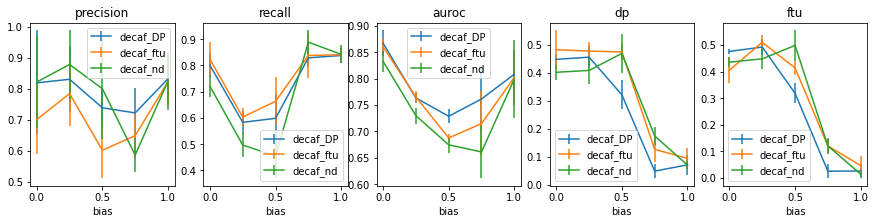

In [33]:
import seaborn as sns
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
 
for key, group in whole_result.groupby('name'):
    group.plot('bias', 'precision_mean', yerr='precision_std',
               label=key, ax=ax1)
ax1.title.set_text('precision')

for key, group in whole_result.groupby('name'):
    group.plot('bias', 'recall_mean', yerr='recall_std',
               label=key, ax=ax2)
ax2.title.set_text('recall')
    
for key, group in whole_result.groupby('name'):
    group.plot('bias', 'auroc_mean', yerr='auroc_std',
               label=key, ax=ax3)
ax3.title.set_text('auroc')


for key, group in whole_result.groupby('name'):
    group.plot('bias', 'dp_mean', yerr='dp_std',
               label=key, ax=ax4)
ax4.title.set_text('dp')

for key, group in whole_result.groupby('name'):
    group.plot('bias', 'ftu_mean', yerr='ftu_std',
               label=key, ax=ax5)
ax5.title.set_text('ftu')
fig.savefig("./exp2.pdf",dpi=150)
plt.show()